# GAN for MIDI Rhythm Generation

preprocess midi data with `0_preprocess_midi.ipynb` in advance

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment

## Constants

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Training

In [3]:
import numpy as np

# # load pianoroll matrix - see "0_preprocess_midi.ipynb"

# matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
# matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
# GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

# print(GENRES_ALL)
# print(matrices_genres.shape)

# # Filter genres 
# GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
# GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# NB_GENRES = len(GENRES)

# print(GENRES_ID_USED)
# print(NB_GENRES, GENRES)

# _drums = []
# _genres = []

# for genre_id, drum in zip(matrices_genres, matrices_drums):
#     if genre_id in GENRES_ID_USED:
#         _drums.append(drum)
#         genre_id = GENRES_ID_USED.index(genre_id)
#         _genres.append(genre_id)

# matrices_drums = np.array(_drums)
# print(matrices_drums.shape)
# matrices_genres = np.array(_genres)
# print(matrices_genres.shape)


In [4]:
import numpy as np

# make sure you have run "0_preprocess_midi.ipynb" in advance
matrices_drums = np.load("./tmp/matrices_drum_groove_genres.npz")['onsets']
matrices_velocities = np.load("./tmp/matrices_drum_groove_genres.npz")['velocities']
matrices_offsets = np.load("./tmp/matrices_drum_groove_genres.npz")['timeshifts']
matrices_genres = np.load("./tmp/matrices_drum_groove_genres.npz")['genre_ids']
GENRES = np.load("./tmp/matrices_drum_groove_genres.npz")['genres']

NB_GENRES = len(GENRES)
print(GENRES)
print(matrices_genres.shape)

# # Filter genres 
# GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
# GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# NB_GENRES = len(GENRES)

# print(GENRES_ID_USED)
# print(NB_GENRES, GENRES)

# _drums = []
# _genres = []

# for genre_id, drum in zip(matrices_genres, matrices_drums):
#     if genre_id in GENRES_ID_USED:
#         _drums.append(drum)
#         genre_id = GENRES_ID_USED.index(genre_id)
#         _genres.append(genre_id)

# matrices_drums = np.array(_drums)
# print(matrices_drums.shape)
# matrices_genres = np.array(_genres)
# print(matrices_genres.shape)


[b'latin' b'jazz' b'soul' b'hiphop' b'rock' b'funk']
(16657,)


In [5]:
def wasserstein_loss(y_true, y_pred):
    return -K.mean(y_true * y_pred)

In [7]:
# def kl_divergence(y_true, y_pred):
#     y_true = K.mean(y_true, axis=1) # mean over timesteps
#     y_pred = K.mean(y_pred, axis=1) 
#     y_true = K.clip(y_true, K.epsilon(), 1) 
#     y_pred = K.clip(y_pred, K.epsilon(), 1)
#     return K.sum(y_true * K.log(y_true / y_pred), axis=-1) # distribution over instruments


## Discriminator

In [10]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional
from keras.layers import Embedding, Concatenate, Activation
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential


# # encoder
# drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order

# x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
# x = Bidirectional(LSTM(64, return_sequences=False, activation='tanh'))(x)
# x = Dense(256)(x)
# x = LeakyReLU(alpha=0.01)(x)
# output = Dense(1)(x)

# discriminator = Model(drum_input, output)
# discriminator.summary()

# optimizer = RMSprop ( lr = 0.0008 )  # higher leraning rate for D
# discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', 
#                       metrics=['accuracy'])

import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Multiply
from keras.layers import Bidirectional, Lambda, Concatenate, Softmax, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.models import Model
from keras import regularizers

droprate = 0.4

# input
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
#input_through = Activation('linear')(drum_input)

# offset_input = Input(shape=(len_seq, nb_notes), name='offset_input')  # tensorflow order

# Conditioning label:
# Integer 0-NB_GENRES denoting the genre G should generate
label_input = Input(shape=(1,), dtype='int32')

# Embedding layer:
# Turns labels into dense vectors of size z_dim
# Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
label_embedding = Embedding(NB_GENRES, np.prod((len_seq, nb_notes)), input_length=1)(label_input)

# Flatten the embedding 3D tensor /into 2D tensor with shape:(batch_size, 28*28*1)
label_embedding = Flatten()(label_embedding)

# Reshape label embeddings to have same dimensions as input images
label_embedding = Reshape((len_seq, nb_notes))(label_embedding)

print(label_embedding.shape)

# Concatenate images with corresponding label embeddings
conditioned = Multiply()([drum_input, label_embedding])

x0 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(conditioned) 
#x0 = BatchNormalization()(x0)
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x0)
#x0 = BatchNormalization()(x0)
#x0 = Dropout(droprate)(x0)

x = Flatten()(x)

# x1 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(offset_input) 
# x1 = BatchNormalization()(x1)
# x1 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x1)
# x1 = BatchNormalization()(x1)
# #x1 = Dropout(droprate)(x1)

# x = Concatenate(axis=-1)([x0, x1])
#x = Dropout(droprate)(x0)
#x = LeakyReLU(alpha=0.01)(x)
x = Dense(512, activation='tanh')(x)
output = Dense(1, activation=None)(x)  # for WGAN, no need to use sigmoid

discriminator = Model([drum_input,label_input], [output])
discriminator.summary()

optimizer = RMSprop ( lr = 0.00005 )  # higher leraning rate for D
discriminator.compile(optimizer=optimizer, loss=[wasserstein_loss], 
                      metrics=['accuracy'])#loss_weights=[1.0, 0.0])

(?, 32, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 32)        192         input_2[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 32)           0           embedding_2[0][0]                
__________________________________________________________________________________________________
drum_input (InputLayer)         (None, 32, 9)        0                                            
_________________________________________________________________________________

## GENERATOR 

In [8]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

len_input = 256

z_input = Input(shape=(len_input,))  # tensorflow order

# Conditioning label
label_input = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(NB_GENRES, len_input, input_length=1)(label_input)
label_embedding = Flatten()(label_embedding)

# Element-wise product of the vectors z and the label embeddings
inputs2 = multiply([z_input, label_embedding])

x = Dense(512)(inputs2)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)

x = LSTM(512, return_sequences=True, activation='tanh')(x) 
x = LSTM(512, return_sequences=True, activation='tanh')(x)
note_out = LSTM(9, return_sequences=True, activation='sigmoid')(x)

generator = Model([z_input, label_input], note_out)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 256)       1536        input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 256)          0           embedding_2[0][0]                
____________________________________________________________________________________________

## ADVERSARIAL MODEL 

In [9]:

from keras.models import Sequential


# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
label_input = Input(shape=(1,), dtype='int32')
img_gan = generator([z_input, label_input])

# training is disable for discriminator in adversarial model
discriminator.trainable = False 

# define output
prediction_gan = discriminator([img_gan, label_input])

# define combined GAN model
gan = Model([z_input, label_input], prediction_gan)

optimizer = RMSprop ( lr = 0.00005 )
gan.compile(optimizer=optimizer, loss=[wasserstein_loss], metrics=['accuracy'],
               loss_weights=[1.0])
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 9)        3898728     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            4732097     model_2[1][0]              

In [10]:
print(gan.metrics_names)
print (discriminator.metrics_names)


['loss', 'accuracy']
['loss', 'accuracy']


## Training

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import random
import pretty_midi
from IPython.display import Audio
from scipy.io import wavfile

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 1.0, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a, threshold=0.0):
    if a is not None:
        a[a < threshold] = 0.0
        
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  
        
        import pretty_midi

def play_drum_matrix(mat, tempo=120.0, threshold=0.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo, threshold=threshold)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120., threshold=0.0):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset >threshold:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data

In [12]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir_prefix = "/tmp/tf_logs_cgan/"
logdir = logdir_prefix + now.strftime("%Y%m%d-%H%M%S") 
cmd = "tensorboard --logdir=" + logdir_prefix
print (cmd)

configure(logdir, flush_secs=5)

tensorboard --logdir=/tmp/tf_logs_cgan/


epoch 220 0
d_loss 0.012825250625610352 a_loss -4.2516823
d_accuracy 0.0


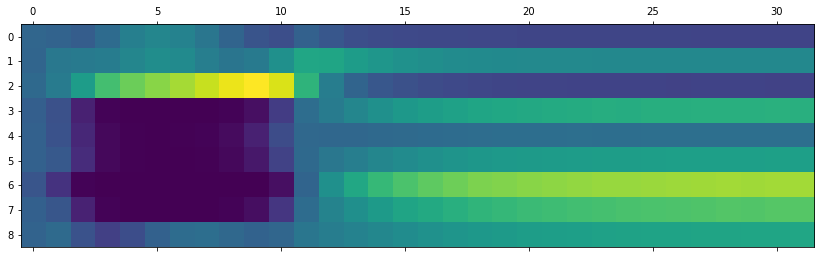

b'jazz'
epoch 220 100
d_loss 0.012825250625610352 a_loss -4.2516823
d_accuracy 0.0


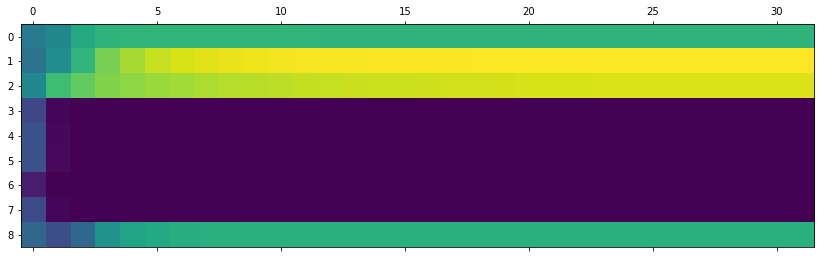

b'soul'
epoch 220 200
d_loss 0.012825441360473634 a_loss -4.2516823
d_accuracy 0.0


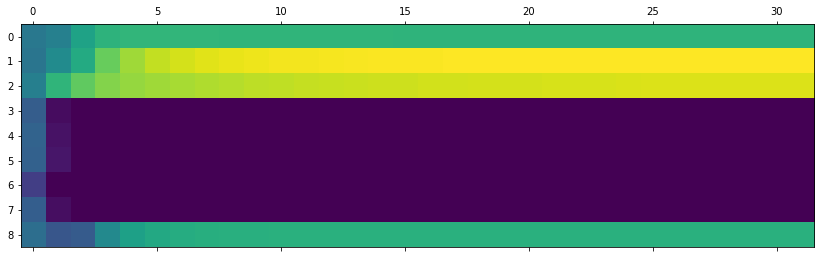

b'soul'
epoch 221 0
d_loss 0.012825250625610352 a_loss -4.2516823
d_accuracy 0.0


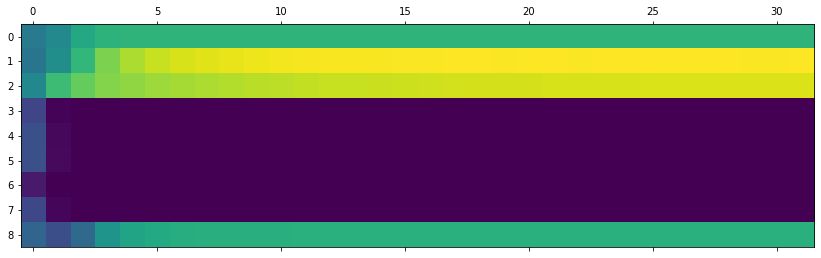

b'rock'
epoch 221 100
d_loss 0.012825727462768555 a_loss -4.2516823
d_accuracy 0.0


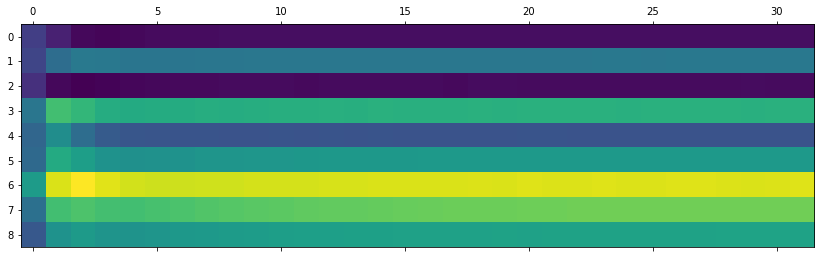

b'hiphop'
epoch 221 200
d_loss 0.012825250625610352 a_loss -4.2516823
d_accuracy 0.0


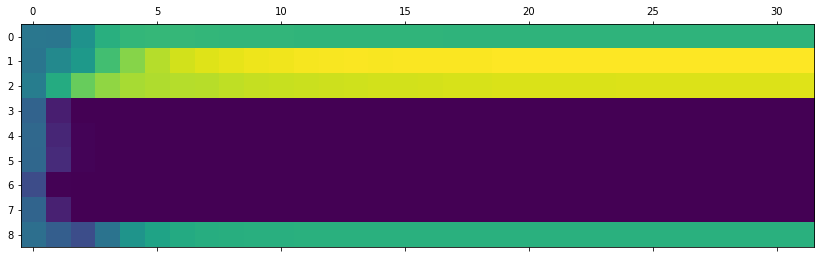

b'funk'


In [ ]:
batch_size = 64
nb_epochs = 300
nb_samples = matrices_drums.shape[0]

D_unrolled = 5
G_unrolled = 1
MAX_LOSS_RATIO = 3.0

clip_threshold = 0.01

# Labels for real images: all ones　# label 0: fake 1: real
real_labels = np.ones((batch_size, 1)) # * 0.9 # one-sided soft labeling

# Labels for fake images: all -1s
fake_labels = np.ones((batch_size, 1))*-1

train_d = True
train_g = True

for epoch in range(nb_epochs):
    
    nb_steps = int(nb_samples/batch_size)
    for repeat in range(nb_steps):
        
        step = nb_steps * epoch + repeat
        
        # Training D
        if train_d:
            
            m_d_loss = 0.0
 #           m_d_w_loss = 0.0
 #           m_d_kl_loss = 0.0
            m_d_accuracy = 0.0
            
            for j in range(D_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_drums.shape[0], size=batch_size)
                drum_train = matrices_drums[random_indices, :, :]
                labels_train = matrices_genres[random_indices]
                
                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict([noise, labels_train])

                # training D
                d_loss_real = discriminator.train_on_batch([drum_train,labels_train], [real_labels])
                d_loss_fake = discriminator.train_on_batch([drum_fake,labels_train], [fake_labels])      
                d_loss, d_accuracy = 0.5 * np.add(d_loss_real, d_loss_fake) # average

                m_d_loss += d_loss
#                m_d_w_loss += d_w_loss
#                 m_d_kl_loss += d_kl_loss
                m_d_accuracy += d_accuracy

                # clip weights for WGAN
                for l in discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
                    l.set_weights(weights)
                
                # cache for later update
    #             cache_weights = discriminator.get_weights()
          
            m_d_loss /= float(D_unrolled)
            m_d_accuracy /= float(D_unrolled)
#             m_d_kl_loss /= float(D_unrolled)
#             m_d_accuracy /= float(D_unrolled)
            
        # store value
        log_value("D loss", m_d_loss, step)  
#        log_value("D Wassterstein loss", m_d_w_loss, step)  
#        log_value("D KL loss", m_d_kl_loss, step)  
        log_value("D accuracy", m_d_accuracy, step) 
        
        # Training G
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here         
            m_a_loss = 0.0
#            m_a_w_loss = 0.0
#            m_a_kl_loss = 0.0
            m_a_accuracy = 0.0  
            
            for j in range(G_unrolled): 
                
                # Get a batch of random labels
                labels_random = np.random.randint(0, NB_GENRES, batch_size).reshape(-1, 1)
                
                noise = get_noise(batch_size, len_input)
                a_loss, a_acc = gan.train_on_batch([noise,labels_random], [y])
            
                m_a_loss += a_loss
#                 m_a_w_loss += a_w_loss
#                 m_a_kl_loss += a_kl_loss
                m_a_accuracy += a_acc
                
            m_a_loss /= float(G_unrolled)
#            m_a_w_loss /= float(G_unrolled)
#            m_a_kl_loss /= float(G_unrolled)
            m_a_accuracy /= float(G_unrolled)
                       
        # store value
        log_value("G loss", m_a_loss, step)
#        log_value("G Wasserstein loss", m_a_w_loss, step)
#        log_value("G KL loss", m_a_kl_loss, step)
        log_value("G accuracy", m_a_accuracy, step)
                    
#         if train_d and train_g:
#             if m_a_loss / m_d_loss > MAX_LOSS_RATIO:
#                 train_d = False
#                 print ("Pausing D")
#             elif m_d_loss / m_a_loss > MAX_LOSS_RATIO:
#                 train_g = False
#                 print ("Pausing G")
#         else:
#             train_d = True
#             train_g = True
            
        # update layer 
#         discriminator.set_weights(cache_weights)
    
        if repeat % 100 == 0:            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "a_loss", a_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
                        
            # sample output
            noise = get_noise(1, len_input)
            labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
            drum_generated = generator.predict([noise,labels_random])            
            plot_drum_matrix(drum_generated)
            
            # sample audio output
            audio_data = play_drum_matrix(np.squeeze(drum_generated))
            wavfile.write("audio/groove_drum_%05d_%05d.wav" % (epoch, repeat), 44100, audio_data)
            print(GENRES[np.squeeze(labels_random)])
            print
            print
            
    # record results per epoch
    log_value("Epoch D loss", m_d_loss, epoch)  
#     log_value("Epoch D Wassterstein loss", m_d_w_loss, epoch)  
#     log_value("Epoch D KL loss", m_d_kl_loss, epoch)  
    log_value("Epoch D accuracy", m_d_accuracy, epoch) 
    log_value("Epoch G loss", m_a_loss, epoch)
#     log_value("Epoch G Wasserstein loss", m_a_w_loss, epoch)
#     log_value("Epoch G KL loss", m_a_kl_loss, epoch)
    log_value("Epoch G accuracy", m_a_accuracy, epoch)                 
    
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/cwan2_generator-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
#         gan.save("./tmp/cwan-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
#         discriminator.save("./tmp/cwan_discriminator-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))
        clear_output(wait=True) # clear here

## Test

In [23]:
from glob import glob
from pathlib import Path
filelist = glob("./tmp/cwan_generator-epoch-*.h5")

length = len("cwan_generator-epoch-034-")

# find generator with the minimum loss
losses = np.array([float(Path(filepath).stem[length:]) for filepath in filelist])
filepath = filelist[np.argmin(losses)]
print (losses)
print(filepath)

[-4.42082 -4.43483  2.29458 -4.42431 -4.42775 -4.43124 -4.41387 -2.69049
 -4.41732 -4.4384 ]
./tmp/cwan_generator-epoch-009--4.43840.h5


In [24]:
from keras.models import load_model

generator_test = load_model(filepath)

/home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


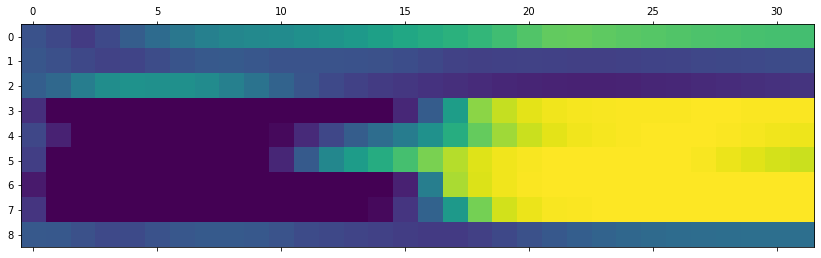

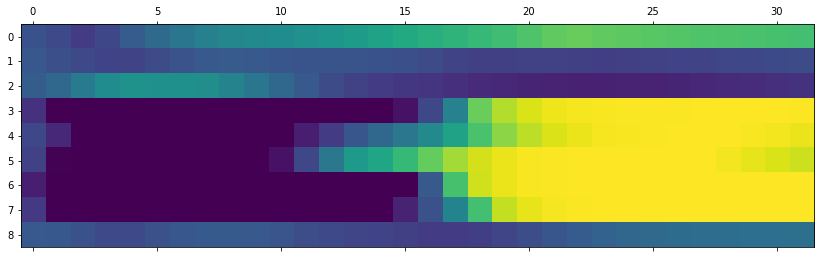

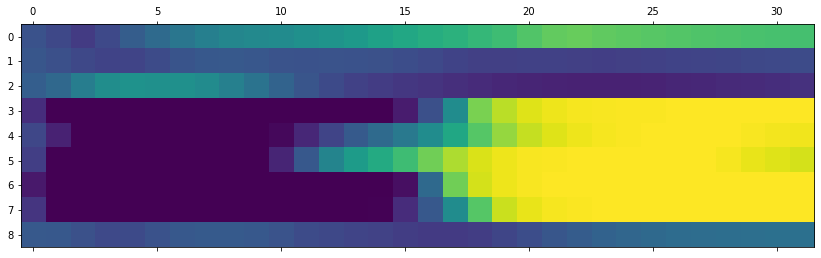

In [25]:
for i in range(3):
    noise = get_noise(1, len_input)
    labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
    drum_generated = generator_test.predict([noise, labels_random])
    plot_drum_matrix(drum_generated)